## Combine Comments and Replies

In [2]:
import os
import json
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
def nest_comments(comments):
    # Build a map of id -> comment
    id_map = {}
    for c in comments:
        if "id" in c and c["id"]:
            c["replies"] = []
            id_map[c["id"]] = c

    # Build the tree
    roots = []
    for c in comments:
        pid = c.get("parent_id")
        if pid == "root" or not pid:
            roots.append(c)
        elif pid in id_map:
            id_map[pid].setdefault("replies", []).append(c)
        # If pid not found, treat as root (optional)

    return roots

output_dir = "output"
submissions = []

for fname in os.listdir(output_dir):
    if fname.endswith(".json"):
        fpath = os.path.join(output_dir, fname)
        with open(fpath, "r", encoding="utf-8") as f:
            video = json.load(f)
        # Prepare comments for nesting
        comments = video.get("Comments", [])
        # If comments are already nested, flatten them for processing
        flat_comments = []
        for c in comments:
            def flatten(comment):
                # Only add id/parent_id if present
                entry = {k: v for k, v in comment.items() if k in ("id", "parent_id", "author", "text", "timestamp")}
                flat_comments.append(entry)
                for reply in comment.get("replies", []):
                    flatten(reply)
            flatten(c)
        # Nest comments
        nested_comments = nest_comments(flat_comments)
        # Build submission
        submission = {
            "title": video.get("Title"),
            "submission_id": fname,
            "author": video.get("Uploader"),
            "score": video.get("Likes", 0),
            "created": None,
            "text": video.get("Description"),
            "comments": nested_comments
        }
        submissions.append(submission)

final_data = {"submissions": submissions}

with open("youtube_structured_Alice.json", "w", encoding="utf-8") as fout:
    json.dump(final_data, fout, ensure_ascii=False, indent=2)

print("youtube_structured_Alice.json created.")

youtube_structured_Alice.json created with nested comments and replies.


## Analysis

In [3]:
def count_replies(comments):
    total = 0
    for comment in comments:
        replies = comment.get('replies', [])
        total += len(replies)
        total += count_replies(replies)
    return total

with open('youtube_structured_Alice.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

submissions = data.get('submissions', [])
num_submissions = len(submissions)
num_comments = sum(len(sub.get('comments', [])) for sub in submissions)
num_replies = sum(count_replies(sub.get('comments', [])) for sub in submissions)

print(f"Number of submissions: {num_submissions}")
print(f"Number of comments: {num_comments}")
print(f"Number of replies: {num_replies}")

Number of submissions: 3
Number of comments: 9654
Number of replies: 4038


## Restructure and Build Reply Graph

In [4]:
with open('youtube_structured_Alice.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

submissions = data.get('submissions', [])

In [5]:
replyGraph = nx.DiGraph()
dSubCommentId = dict()

In [7]:
for vid in submissions:
    for comment in vid['comments']:
        author = comment['author']
        if author is not None and author != '':
            if author in replyGraph.nodes:
                replyGraph.nodes[author]['subNum'] = replyGraph.nodes[author].get('subNum', 0) + 1
            else:
                replyGraph.add_node(author, subNum=1)
            
    submissionIds = [comment['id'] for comment in vid['comments']]
    
    for comment in vid['comments']:
        # Map comment id to author
        if comment['author'] is not None and comment['author'] != '':
            dSubCommentId[comment['id']] = comment['author']

        # For each reply to this comment
        for reply in comment.get('replies', []):
            reply_author = reply.get('author')
            parent_author = comment.get('author')
            if (reply_author is not None and reply_author != '' and
                parent_author is not None and parent_author != ''):
                # Only proceed if reply author is not the same as parent comment's author
                if reply_author != parent_author:
                    # Check if edge exists from reply_author to parent_author
                    if replyGraph.has_edge(reply_author, parent_author):
                        # Increment replyNum attribute
                        replyGraph[reply_author][parent_author]['replyNum'] = replyGraph[reply_author][parent_author].get('replyNum', 0) + 1
                    else:
                        # Add new edge with replyNum = 1
                        replyGraph.add_edge(reply_author, parent_author, replyNum=1)

In [8]:
print(replyGraph.nodes)

['@Tomtycoon', '@bryansheff', '@aeh5109', '@davidstone281', '@carlosfer2201', '@chanceyporter6178', '@thelittleal1212', '@GBop89', '@vidverbic', '@psychonaut1502', '@planetxchuu', '@jasons9895', '@bean_bttf3', '@P-C-Principle', '@somerandomguy9891', '@M0b1us_118', '@PeterAnsellVideoEditor', '@NefariousDreary', '@VanguardJester', '@rattlebear25', '@avacornthelastponybender8583', '@EliasValadez-pu1iq', '@alejandroyava', '@danielscott5673', '@LooneyTunes1984-g7m', '@BlueB360', '@ChrisScottStockman', '@TheIllusiveMan11', '@yama5182', '@rits7995', '@Rainok', '@ciscotheinkboi', '@BC92Se7en', '@PhoenixGamerxx96', '@TheErikalovey', '@battleborn1055', '@michaellucejr.6374', '@wolfpackflt670', '@ruggiebuggie3195', '@EnsignRedSquad', '@thevaccinator666', '@iambathman9916', '@nickwerner7983', '@rmsgrey', '@TJRymer89', '@shrutivipul9541', '@Angelbird57438', '@cardboardbox5704', '@demorunnertimmedrt4432', '@CamdenAndrews-hl3hu', '@Kraken-rex9743', '@disneyvillainsfan1666', '@akirayamaguchithekitsune

In [9]:
sFileName = 'alice_youtube_replyGraph.graphml'
nx.readwrite.write_graphml(replyGraph, sFileName)

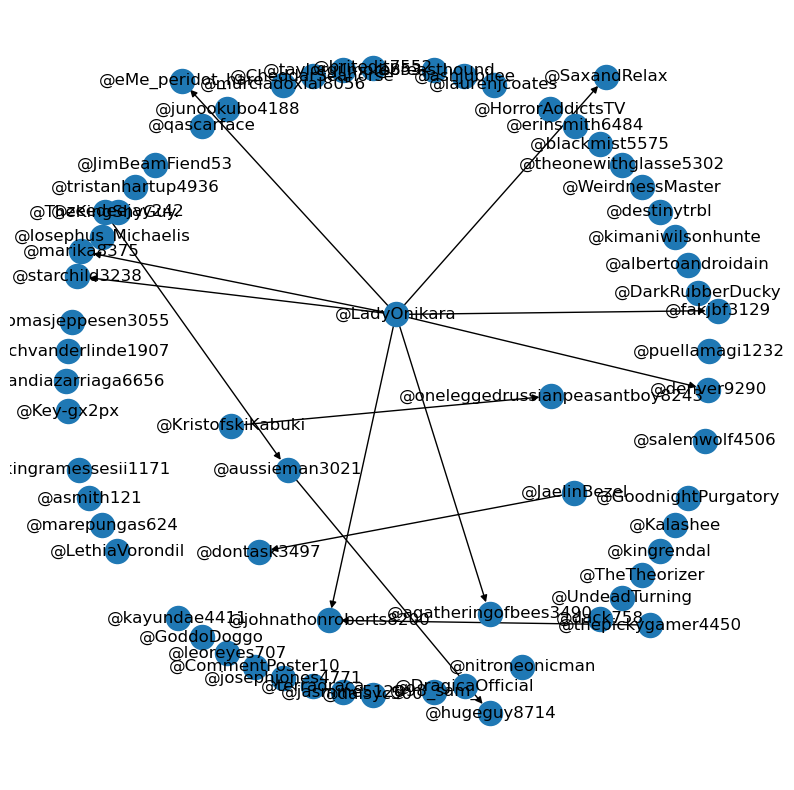

In [10]:
# Filter nodes with degree > 10
high_degree_nodes = [n for n in replyGraph.nodes if replyGraph.degree(n) > 10]

# Create a subgraph
subG = replyGraph.subgraph(high_degree_nodes).copy()

# Draw the subgraph
plt.figure(figsize=(10, 10))
nx.draw_networkx(subG, arrows=True, with_labels=True, pos=nx.kamada_kawai_layout(subG, scale=10))
plt.axis('off')
plt.show()


## Find Centralities

In [12]:
sFileName = 'alice_youtube_replyGraph.graphml'

In [13]:
replyGraph = nx.readwrite.read_graphml(sFileName)

lDegCentrality = nx.degree_centrality(replyGraph)
lEigenvectorCentrality = nx.eigenvector_centrality(replyGraph, max_iter=1000)
lKatzCentrality = nx.katz_centrality(replyGraph)
lPageRank = nx.pagerank(replyGraph)
lClosenessCentrality = nx.closeness_centrality(replyGraph)
lBetweennessCentrality = nx.betweenness_centrality(replyGraph)

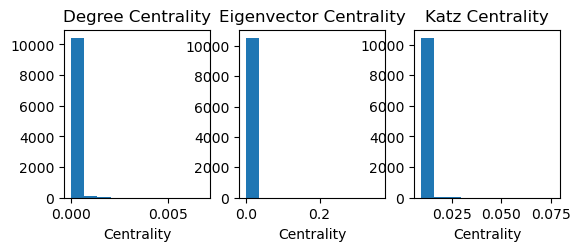

In [14]:
plt.subplot(2, 3, 1)
plt.hist(list(lDegCentrality.values()))
plt.title("Degree Centrality")
plt.xlabel("Centrality")

# eigenvector centrality
plt.subplot(2, 3, 2)
plt.hist(list(lEigenvectorCentrality.values()))
plt.title("Eigenvector Centrality")
plt.xlabel("Centrality")
# katz centrality
plt.subplot(2, 3, 3)
plt.hist(list(lKatzCentrality.values()))
plt.title("Katz Centrality")
plt.xlabel("Centrality")

plt.show()

In [15]:
# Top 5 by lDegCentrality
top_ldeg = sorted(lDegCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 by lDegCentrality:")
for node, score in top_ldeg:
    print(f"{node}: {score}")

# Top 5 by lEigenvectorCentrality
top_leigen = sorted(lEigenvectorCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by lEigenvectorCentrality:")
for node, score in top_leigen:
    print(f"{node}: {score}")

# Top 5 by lKatzCentrality
top_lkatz = sorted(lKatzCentrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 by lKatzCentrality:")
for node, score in top_lkatz:
    print(f"{node}: {score}")

Top 5 by lDegCentrality:
@Key-gx2px: 0.006820765441455097
@laurenjcoates: 0.005020841227737779
@kimaniwilsonhunte: 0.0044524441076165214
@fakjbf3129: 0.0034103827207275484
@KristofskiKabuki: 0.003220917014020462

Top 5 by lEigenvectorCentrality:
@Iosephus_Michaelis: 0.3590147707896874
@hugeguy8714: 0.25864307341927634
@lulubella333: 0.2585117770505183
@Draukagrissah: 0.25849427086801724
@tskhako4339: 0.25847676468551617

Top 5 by lKatzCentrality:
@Key-gx2px: 0.07633270961953725
@laurenjcoates: 0.05883203960920433
@kimaniwilsonhunte: 0.053060542052605165
@fakjbf3129: 0.04282078832315504
@KristofskiKabuki: 0.040493571566461835


In [16]:
# eigenvector centrality, store in node attribute 'eigen'
for nodeId, cent in lEigenvectorCentrality.items():
    replyGraph.nodes[nodeId]['eigen'] = float(cent)
    
# Katz centrality, store in node attribute 'katz'
for nodeId, cent in lKatzCentrality.items():
    replyGraph.nodes[nodeId]['katz'] = float(cent)
    
nx.readwrite.write_graphml(replyGraph, 'mod' + sFileName, infer_numeric_types=True)

In [17]:
# Compute clustering
print('Global clustering coefficient/transitivity: {}'.format(nx.transitivity(replyGraph)))

# Compute components
print('number of strongly connected components: {}'.format(nx.number_strongly_connected_components(replyGraph)))
print('number of weakly connected components: {}'.format(nx.number_weakly_connected_components(replyGraph)))

# Compute bridges
print(list(nx.bridges(replyGraph.to_undirected())))

Global clustering coefficient/transitivity: 0.0018679950186799503
number of strongly connected components: 10557
number of weakly connected components: 7965
[('@GBop89', '@katieblade7083'), ('@GBop89', '@gustavrosengren6605'), ('@P-C-Principle', '@scipunkdollstudios4081'), ('@nickwerner7983', '@CelStacker'), ('@nickwerner7983', '@KoreeluStromboli'), ('@nickwerner7983', '@ok_uh_eli_i_guess376'), ('@nickwerner7983', '@vincentmacefephase2718'), ('@Angelbird57438', '@NaelynAngelgamerboi'), ('@Kraken-rex9743', '@Quiz1master5'), ('@Kraken-rex9743', '@KristofskiKabuki'), ('@disneyvillainsfan1666', '@EldritchHarrr'), ('@depresso___espresso', '@ChannelAwesome'), ('@bloodrunsclear', '@TruieseSmith'), ('@ScrambledAndBenedict', '@AnimeWolf5193'), ('@matityaloran9157', '@AnimeWolf5193'), ('@jareththegoblinking3191', '@dufmic1369'), ('@jareththegoblinking3191', '@qazertland'), ('@jareththegoblinking3191', '@Rystefn'), ('@jareththegoblinking3191', '@giddytv611'), ('@nathanblevins9870', '@kingalec6446

## Community Detection

In [18]:
import community

In [19]:
def dictToSetFormat(dComms, maxCommNum):
    lGroundTruth = [set() for i in range(maxCommNum)]
    for (name, clusId) in dComms.items():
        lGroundTruth[clusId].add(name)
    return lGroundTruth

In [20]:
replyGraph = nx.readwrite.read_graphml(sFileName)

# Implement CPM
k=3
lCpmComms = list(nx.algorithms.community.k_clique_communities(nx.to_undirected(replyGraph), k=k))
print('Number of communities found: {}'.format(len(lCpmComms)))

# Implement Louvain
dLouvainComms = community.best_partition(replyGraph.to_undirected())
print(dLouvainComms)

louvanCommNum = max([y for (x,y) in dLouvainComms.items()]) + 1
lLouvainComms = dictToSetFormat(dLouvainComms, louvanCommNum)

# Write out cpm and Louvain values to node attributes of graph
# cpm labels, stored in node attribute 'cpmClusId'
for clusId, lComms in enumerate(lCpmComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['cpmClusId'] = clusId
        
# louvain labels, stored in node attribute 'louvain'
for clusId, lComms in enumerate(lLouvainComms):
    for nodeId in lComms:
        replyGraph.nodes[nodeId]['louvain'] = clusId
        
nx.readwrite.write_graphml(replyGraph, 'mod2' + sFileName, infer_numeric_types=True)

Number of communities found: 5
{'@Tomtycoon': 0, '@bryansheff': 1, '@aeh5109': 2, '@davidstone281': 3, '@carlosfer2201': 4, '@chanceyporter6178': 5, '@thelittleal1212': 6, '@GBop89': 7, '@vidverbic': 8, '@psychonaut1502': 9, '@planetxchuu': 10, '@jasons9895': 11, '@bean_bttf3': 12, '@P-C-Principle': 13, '@somerandomguy9891': 14, '@M0b1us_118': 15, '@PeterAnsellVideoEditor': 16, '@NefariousDreary': 13, '@VanguardJester': 17, '@rattlebear25': 18, '@avacornthelastponybender8583': 19, '@EliasValadez-pu1iq': 20, '@alejandroyava': 21, '@danielscott5673': 22, '@LooneyTunes1984-g7m': 13, '@BlueB360': 23, '@ChrisScottStockman': 24, '@TheIllusiveMan11': 25, '@yama5182': 26, '@rits7995': 27, '@Rainok': 28, '@ciscotheinkboi': 29, '@BC92Se7en': 30, '@PhoenixGamerxx96': 31, '@TheErikalovey': 32, '@battleborn1055': 33, '@michaellucejr.6374': 34, '@wolfpackflt670': 35, '@ruggiebuggie3195': 36, '@EnsignRedSquad': 37, '@thevaccinator666': 38, '@iambathman9916': 39, '@nickwerner7983': 103, '@rmsgrey': 41